In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
from helper import *
from load_dataframes import load_all
from plates import plates,timestep
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
import seaborn as sns
import matplotlib.pyplot as plt
logging.getLogger().setLevel(logging.WARNING)

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
df,final_data = load_all(plates)

C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:111: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['start'] = pd.to_datetime(df_sum['start'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:112: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['crossed']  = pd.to_datetime(df_sum['crossed'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:113: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsi

In [3]:
def calculate_derivative(df, column, new_column, window=1):
    # Ensure the DataFrame is sorted by 'unique_id' and 'time_since_begin_h'
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    
    # Calculate the time difference and value difference over the desired window
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_h'].transform(lambda x: x.diff(window)).fillna(0)
    df['value_diff'] = df.groupby('unique_id')[column].transform(lambda x: x.diff(window)).fillna(0)
    df[new_column] = df.apply(lambda x: x['value_diff'] / x['time_diff'] if x['time_diff'] != 0 else None, axis=1)

    # Drop the helper columns
    df.drop(['time_diff', 'value_diff'], axis=1, inplace=True)
    # Calculate calculate_derivative(final_data,f'tot_surface_area_study',f'derivative_SA', window=5)

# the derivative (value difference divided by time difference)
    # Be cautious about dividing by zero. If 'time_diff' is 0, set derivative to NaN or handle accordingly.

def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    df['time_since_begin_hour'] = df['time_since_begin_h']
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)
calculate_integral(final_data,f'tot_surface_area_study',f'integrated_SA')
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_biovolume', window=5)
calculate_derivative(final_data,f'tot_volume',f'derivative_tot_biovolume', window=5)
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_biovolume_smooth', window=10)


Vmax = 3e-9*25 #ugP/um2/hour
density = 1e-6 #ug/um3
dry_wet_ratio = 0.3
carbon_ratio = 0.5
carbon_ratio_spore = 0.9
dry_wet_ratio_spore = 0.9
density_spore = 0.9e-6
respiration_ratio = 0.5
final_data['P_rate'] =final_data['tot_surface_area_study']*Vmax
final_data['C_rate'] = final_data['derivative_biovolume']*density*dry_wet_ratio*carbon_ratio/respiration_ratio
final_data['totC_hypha'] = final_data['tot_biovolume_study']*density*dry_wet_ratio*carbon_ratio
final_data['tot_volume'] = final_data['spore_volume']+final_data['tot_biovolume_study']
final_data['totC_spore'] = final_data['spore_volume']*density_spore*dry_wet_ratio_spore*carbon_ratio_spore
final_data['totC_tot'] = final_data['totC_hypha'] + final_data['totC_spore']
calculate_derivative(final_data,f'totC_tot',f'derivative_C', window=5)

calculate_derivative(final_data,f'area_sep_comp',f'derivative_area', window=5)

final_data = final_data.reset_index(drop=True)
final_data_select = final_data.loc[final_data['time_since_begin_h_shifted']<=150]

max_c_rate_time = final_data_select.loc[final_data_select.groupby('unique_id')['C_rate'].idxmax(), ['unique_id', 'time_since_begin_h_shifted']]

# Step 2: Merge this information back to the original DataFrame
final_data = final_data.merge(max_c_rate_time, on='unique_id', suffixes=('', '_max_c_rate'))

In [4]:
calculate_derivative(final_data,f'tot_surface_area_study',f'derivative_SA', window=5)
calculate_derivative(final_data,f'totC_tot',f'derivative_C', window=5)

calculate_derivative(final_data,f'area_sep_comp',f'derivative_area', window=5)
final_data['instant_SA_dens'] = final_data['derivative_SA']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_BV', window=5)
final_data['instant_BV_dens'] = final_data['derivative_BV']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_length_study',f'derivative_L', window=5)
final_data['instant_L_dens'] = final_data['derivative_L']/final_data['derivative_area']
final_data['instant_C_dens'] = final_data['derivative_C']/final_data['derivative_area']

final_data['instant_radius'] = final_data['instant_BV_dens']/final_data['instant_SA_dens']*2


In [5]:
df['FungalSide'] = df['FungalSide'].fillna("100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")

df['treatment'] = df['treatment'].replace("1P100N100C","1P/100N/100C")
df['fungus'] = df['fungus'].replace("A5sp3","A5")
df['category_combination'] = df[['treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)
df['size_point'] = 20
marker_symbols = {
    "C2": 'circle',
    "A5": 'square',
    "Agg": 'diamond',
    "Clarum": 'cross',
    "C3": 'star',
    
    
    # Add more mappings as needed
}

n_colors = len(df['fungus'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(df['fungus'].unique(), palette))
df['full_category_combination'] = df[['fungus','treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)

# Map the strain to the marker symbol in the DataFrame
df['marker'] = df['fungus'].map(marker_symbols)


In [6]:
final_data['strain'] = final_data['strain'].str.replace("'","")
n_colors = len(df['strain'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(final_data['strain'].unique(), palette))

In [7]:
strain_to_color = {'C2': (0.17058823529411765, 0.4946558433997788, 0.9667184042691874),
 'A5': (0.16666666666666663, 0.8660254037844386, 0.8660254037844387),
 'Agg': (0.503921568627451, 0.9999810273487268, 0.7049255469061472),
 'Clarum': (0.8333333333333333, 0.8660254037844387, 0.5000000000000001),
 'C3': (1.0, 0.4946558433997788, 0.2558427775944356)}

2024-03-07 09:06:39,092-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


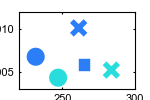

In [8]:
bin_size = 30
cm = 1/2.54  # centimeters in inches
select = final_data
select = final_data.loc[final_data['hull_speed']>0].copy()
select['hull_speed_binned'] = select['hull_speed'].astype(int)//bin_size*bin_size
select= select[select['instant_C_dens']>0]
select= select[select['instant_C_dens']<=0.025]
# select= select[select['real_root']=="Carrot Toby"]
select= select[select['real_root'].isin(["Carrot Toby","Carrot Vasilis"])]
select= select[select['strain'].isin(["A5","C2"])]

# select= select[select['fungalC']=="100P/100N/100C"]
select['root_fungal_combo'] = select['real_root'] + '_' + select['fungalC']
select = select[select['time_since_begin_h_shifted'] < select['time_since_begin_h_shifted_max_c_rate']+20]
# select = select[select['time_hour_binned'] <= 50]
# select = select[select['time_hour_binned'] >= 0]

summary = select.groupby(["strain", 'time_hour_binned','real_root','fungalC','root_fungal_combo']).agg({
    'hull_speed': 'median',
    'instant_SA_dens': 'median',
    'radius': 'median',
    'instant_BV_dens': 'count',
    'instant_L_dens': 'median',
    'instant_C_dens': 'median',
    
}).rename(columns={'instant_BV_dens': 'count'})
summary = summary[summary['count']>7]
summary = summary.reset_index()
fig,ax = plt.subplots(figsize = (1.5,1))

# sns.regplot(data=summary, x='hull_speed', y='instant_L_dens',scatter = False,color = "black")
summary = select.groupby(["strain",'real_root','fungalC','root_fungal_combo'])[['hull_speed','hull_speed_binned','instant_SA_dens','radius','instant_BV_dens','instant_L_dens','instant_C_dens']].median()
sns.scatterplot(data=summary, x='hull_speed', y='instant_C_dens', 
                hue="strain", style="root_fungal_combo", s=200,palette=strain_to_color)
# summary2 = select.groupby(["strain", 'time_hour_binned','root_fungal_combo','fungalC','real_root']).agg({
#     'hull_speed': 'median',
#     'instant_SA_dens': 'median',
#     'radius': 'median',
#     'instant_BV_dens': 'count',
#     'instant_L_dens': 'median',
#     'instant_C_dens': 'median',
    
# }).rename(columns={'instant_BV_dens': 'count'})
# sns.scatterplot(data=summary2, x='hull_speed', y='instant_C_dens', 
#                 hue="strain", style="root_fungal_combo", s=50,alpha = 0.3)
ax.legend('')
summary['size_point'] = 20
summary['fungus'] = summary.index
ax.set_xlabel('$v_{wave}$ (um/h)')
ax.set_ylabel('$d_{Carbon}$ \n ($\mu g/mm^2$)')
plt.legend().remove()
# plt.tight_layout()
path_figure = r"C:\Users\coren\Documents\PhD\paper\PandC\FigS1"
ax.set_xlim(220,300)
ax.set_ylim(0.003,0.012)

plt.savefig(os.path.join(path_figure,'FigureA.pdf'), transparent=True, bbox_inches='tight')


In [9]:
select['fungalC'].unique()

array(['100P/100N/100C', '0P/100N/100C'], dtype=object)

In [10]:
select[select['fungalC']=='0P/100N/100C']['unique_id'].unique()

array([4.68202308e+10, 4.71202308e+10])